<a href="https://colab.research.google.com/github/21Ovi/NoteVision/blob/main/NoteVision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

Welcome to **NoteVision**, a project aimed at converting handwritten notes into digital text using machine learning techniques. This notebook will guide you through the entire process of building a handwriting recognition model using TensorFlow and Python. The dataset used in this project is sourced from Kaggle, consisting of over 400,000 handwritten names.

### Notebook Overview:
1. **Data Preprocessing**: We begin by loading and preparing the dataset, including image normalization and label encoding.
2. **Model Building**: A deep learning model is constructed using TensorFlow, optimized for recognizing handwritten text.
3. **Training & Validation**: The model is trained on the dataset and validated for accuracy using Google Colab's GPU resources.
4. **Evaluation**: Performance metrics and insights are gathered to assess the effectiveness of the model.
5. **Final Model**: The final trained model is saved and ready for deployment.

This notebook provides a step-by-step process for building a handwriting recognition system, complete with explanations and code snippets. Feel free to explore and modify it according to your needs!


## All Imports

In [1]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout
from keras.optimizers import Adam

## Loading Dataset from Google Drive

In [2]:
# Unzip the dataset to a folder in Colab
!unzip -q /content/drive/MyDrive/datasets/archive.zip -d /content/data

In [3]:
!ls /content/data

test_v2   validation_v2		    written_name_train_v2.csv
train_v2  written_name_test_v2.csv  written_name_validation_v2.csv


## Load and view data

In [4]:
# Load the CSV files using the correct paths
train = pd.read_csv('/content/data/written_name_train_v2.csv')
valid = pd.read_csv('/content/data/written_name_validation_v2.csv')
test = pd.read_csv('/content/data/written_name_test_v2.csv')

# Display the first few rows of each dataset to verify
print("Train Data:")
print(train.head())
print("\nValidation Data:")
print(valid.head())
print("\nTest Data:")
print(test.head())


Train Data:
          FILENAME   IDENTITY
0  TRAIN_00001.jpg  BALTHAZAR
1  TRAIN_00002.jpg      SIMON
2  TRAIN_00003.jpg      BENES
3  TRAIN_00004.jpg    LA LOVE
4  TRAIN_00005.jpg     DAPHNE

Validation Data:
              FILENAME    IDENTITY
0  VALIDATION_0001.jpg       BILEL
1  VALIDATION_0002.jpg  LAUMIONIER
2  VALIDATION_0003.jpg         LEA
3  VALIDATION_0004.jpg   JEAN-ROCH
4  VALIDATION_0005.jpg        RUPP

Test Data:
        FILENAME  IDENTITY
0  TEST_0001.jpg     KEVIN
1  TEST_0002.jpg  CLOTAIRE
2  TEST_0003.jpg      LENA
3  TEST_0004.jpg     JULES
4  TEST_0005.jpg   CHERPIN


### View data

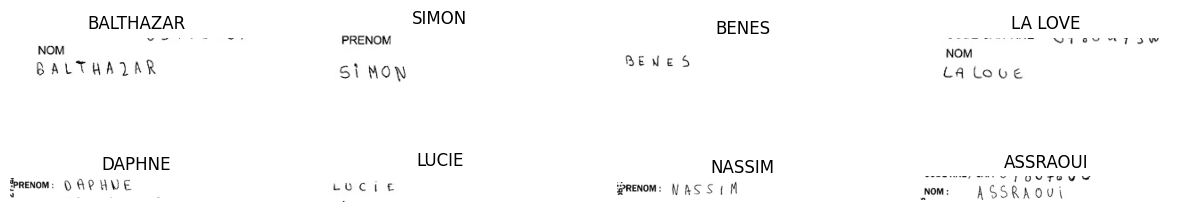

In [5]:
plt.figure(figsize=(15, 10))

for i in range(8):
  ax = plt.subplot(2, 4, i+1)
  # Updated image path to include the additional 'train' folder
  img_dir = '/content/data/train_v2/train/' + train.loc[i, 'FILENAME']
  image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)

  # Check if the image was loaded properly
  if image is None:
    print(f"Image not found or failed to load: {img_dir}")
    continue

  plt.imshow(image, cmap='gray')
  plt.title(train.loc[i, 'IDENTITY'], fontsize=12)
  plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)


In [6]:
train_size = len(train)
print(f"Number of samples in the training set: {train_size}")

valid_size = len(valid)
print(f"Number of samples in the validation set: {valid_size}")

test_size = len(test)
print(f"Number of samples in the testing set: {test_size}")

Number of samples in the training set: 330961
Number of samples in the validation set: 41370
Number of samples in the testing set: 41370


## Cleaning Data

In [7]:
print("Number of NaNs in train set       :", train['IDENTITY'].isnull().sum())
print("Number of NaNs in validation set: :", valid['IDENTITY'].isnull().sum())
print("Number of NaNs in test set        :", test['IDENTITY'].isnull().sum())

Number of NaNs in train set       : 565
Number of NaNs in validation set: : 78
Number of NaNs in test set        : 70


In [8]:
train.dropna(inplace=True)
valid.dropna(inplace=True)

Also, there are some images in this dataset with the label of `UNREADABLE`, we need to get rid of them in order to clean data.

<ipython-input-9-5e0fe0d47bfd>:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(2, 3, i+1)


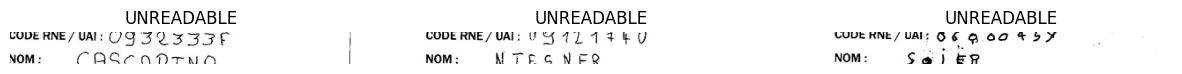

In [9]:
unreadable = train[train['IDENTITY'] == 'UNREADABLE']
unreadable.reset_index(inplace=True, drop=True)

plt.figure(figsize=(15, 10))
for i in range(6):
  ax = plt.subplot(2, 3, i+1)
  img_dir = '/content/data/train_v2/train/' + unreadable.loc[i, 'FILENAME']
  image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
  plt.imshow(image, cmap='gray')
  plt.title(unreadable.loc[i, 'IDENTITY'], fontsize=12)
  plt.axis('off')

  plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [10]:
train = train[train['IDENTITY'] != 'UNREADABLE']
valid = valid[valid['IDENTITY'] != 'UNREADABLE']

In [11]:
train.reset_index(inplace=True, drop=True)
valid.reset_index(inplace=True, drop=True)

In [12]:
train_size = len(train)
print(f"Number of samples in the training set: {train_size}")

valid_size = len(valid)
print(f"Number of samples in the validation set: {valid_size}")

test_size = len(test)
print(f"Number of samples in the testing set: {test_size}")

Number of samples in the training set: 330294
Number of samples in the validation set: 41280
Number of samples in the testing set: 41370


## Preprocessing and preparing the images for training

* The images are loaded as grayscale and reshaped to width 256 and height 64.
* The width and height are cropped if they are greater than 256 and 64 respectively. If they are smaller, then the image is padded with white pixels. Finally the image is rotated clockwise to bring the image shape to (x, y).
* The image is then normalized to range [0, 1]

In [13]:
def preprocess(img):
    (h, w) = img.shape

    final_img = np.ones([64, 256])*255 # blank white image

    # crop
    if w > 256:
        img = img[:, :256]

    if h > 64:
        img = img[:64, :]


    final_img[:h, :w] = img
    return cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE)

The model will be trained on 30000 images and validate on 3000 images



In [ ]:
train_x = []

for i in range(train_size):
    img_dir = '/content/data/train_v2/train/'+train.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    train_x.append(image)

In [ ]:
valid_x = []

for i in range(valid_size):
    img_dir = '/content/data/validation_v2/validation/'+valid.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    valid_x.append(image)